# Settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive 
import os
import matplotlib.pyplot as plt

drive.mount("/content/gdrive", force_remount=True)
os.chdir("/content/gdrive/MyDrive/xai-lab/")


Mounted at /content/gdrive


In [3]:
!pip install lime

# Object detector

In [35]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, fasterrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from lime.lime_image import LimeImageExplainer
from src.faster_rcnn import fasterrcnn_resnet18_fpn

from src.utils import jaccard

# device = 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# our dataset has two classes only - background and person
num_classes = 91

In [36]:
# load an instance segmentation model pre-trained pre-trained on COCO
# model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, num_classes=num_classes)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained_backbone=True, pretrained=True)
# model = fasterrcnn_resnet18_fpn(pretrained_backbone=True, num_classes=num_classes)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=num_classes)

# load model checkpoint
path = os.path.join(os.getcwd(), "./checkpoints/faster_rcnn_resnet50_91_classes_epoch_pretrained_COCO.ckpt")
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])

model.to(device) 

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# PennFudan Dataset

In [37]:
import sys
sys.path.append("./detection")
from pennfudan_dataset import PennFudanDataset, get_transform

# use our dataset and defined transformations
dataset = PennFudanDataset('./PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('./PennFudanPed', get_transform(train=False))
# changing to array


# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

In [ ]:
# creating test image
num_image_test = 5
image_test = torch.utils.data.Subset(dataset_test, indices[:num_image_test])

# COCO Dataset

In [5]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(coco_annotation[i]['category_id'])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [6]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)# path to your own data and coco file

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

path2train="./coco/val2017"
path2trainjson="./coco/annotations/instances_val2017.json"
path2val="./coco/val2017"
path2valjson="./coco/annotations/instances_val2017.json"
# create own Dataset
dataset = CocoDataset(root=path2train,
                          annotation=path2trainjson,
                          transforms=get_transform()
                          )

dataset_test = CocoDataset(root=path2val,
                          annotation=path2valjson,
                          transforms=get_transform()
                          )
# Batch size
train_batch_size = 1

# own DataLoader
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!
loading annotations into memory...
Done (t=0.70s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [7]:
# creating test image
indices = torch.randperm(len(dataset)).tolist()
num_image_test = 100
image_test = torch.utils.data.Subset(dataset_test, indices[:num_image_test])

# Visualize the Detection



In [38]:
# pick one image from the test set
img = dataset_test[0][0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [39]:
from PIL import Image, ImageDraw

result = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
image = ImageDraw.Draw(result)  

for bbox in prediction[0]["boxes"]:
    image.rectangle(bbox.cpu().numpy().tolist(), outline ="red")

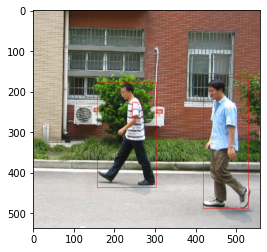

In [40]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(result)

In [41]:
print(prediction)

[{'boxes': tensor([[419.4174, 165.4901, 530.6624, 488.1110],
        [158.0410, 177.9133, 303.9079, 436.5741],
        [244.4374, 226.2559, 271.0301, 265.0537]], device='cuda:0'), 'labels': tensor([ 1,  1, 27], device='cuda:0'), 'scores': tensor([0.9987, 0.9978, 0.0594], device='cuda:0')}]


# Explanations

## Import explainer

In [42]:
from src.sodexplainer import SODExplainer
explainer_sodex = SODExplainer(model=model)

## Lime Explanation

In [45]:
image_test = img
image_test = image_test.permute(1,2,0).detach().numpy()
image_test = image_test.astype('double')

In [27]:
explanation = explainer_sodex.get_lime_explanation(image_test,dataset_test[0], num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score a

(-0.5, 585.5, 639.5, -0.5)

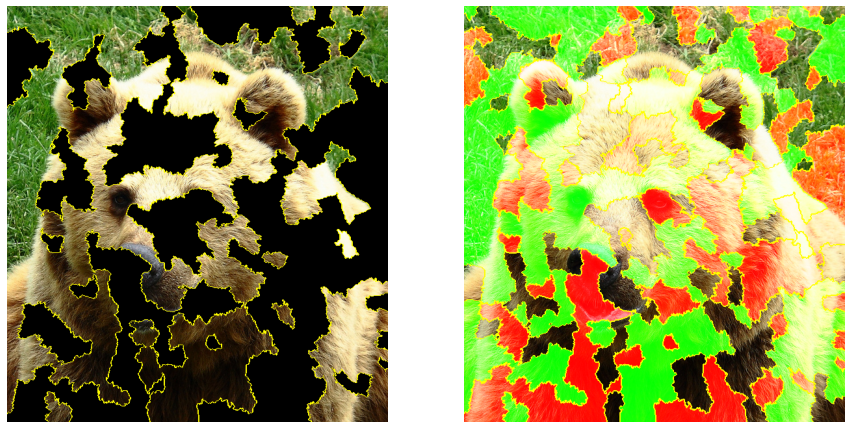

In [28]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=200, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=200, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

## Rise explanation

In [ ]:
image_test = img.permute(1,2,0)
# image_test = image_test.detach().numpy().astype('double')
sal, preds, masks = explainer_sodex.get_rise_explanation(image_test, N=1000, s=10, p1=0.5, class_index=1)
# sal, preds, masks = explainer_sodex.get_rise_explanation(torch.from_numpy(image_test), N=10, s=10, p1=0.5)

Explaining:  66%|██████▌   | 660/1000 [03:23<01:43,  3.29it/s]

In [ ]:
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(sal.cpu().numpy(), cmap='jet', alpha=0.8)
plt.show()

# Evaluation

In [ ]:
from src.eval import evaluate, get_maximum_point

## Pointing Game Accuracy

Run lime explanation on 5 images with num_samples=1000.

In [ ]:
explanations = []
for img in image_test:
  img_array = img[0].permute(1,2,0).detach().numpy().astype('double')
  explanation = explainer_sodex.get_lime_explanation(img_array,img, num_samples=1000)
  explanations.append(explanation)

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Intercept 0.010332279430503011
Prediction_local [-0.00206904]
Right: tensor(0.0010, device='cuda:0')
Intercept 0.9896677205694969
Prediction_local [1.00206904]
Right: tensor(0.9990, device='cuda:0')


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.005152904641164099
Prediction_local [-0.00064963]
Right: tensor(0.0011, device='cuda:0')
Intercept 0.994847095358836
Prediction_local [1.00064963]
Right: tensor(0.9989, device='cuda:0')


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.0029710552936178213
Prediction_local [9.33197434e-05]
Right: tensor(0.0006, device='cuda:0')
Intercept 0.9970289447063823
Prediction_local [0.99990668]
Right: tensor(0.9994, device='cuda:0')


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.013610226113775468
Prediction_local [-0.00323845]
Right: tensor(0.0011, device='cuda:0')
Intercept 0.9863897738862247
Prediction_local [1.00323845]
Right: tensor(0.9989, device='cuda:0')


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.01754466429014554
Prediction_local [-0.00874595]
Right: tensor(0.0001, device='cuda:0')
Intercept 0.9824553357098544
Prediction_local [1.00874595]
Right: tensor(0.9999, device='cuda:0')


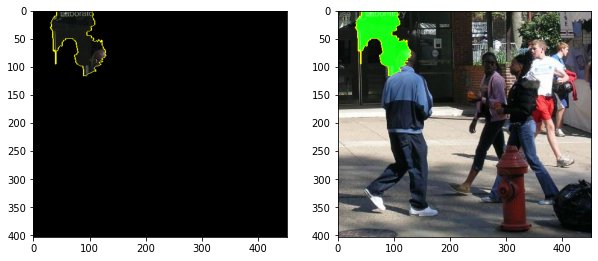

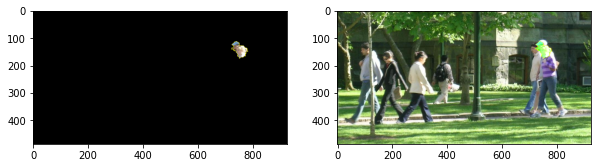

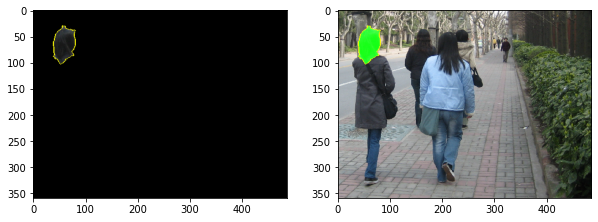

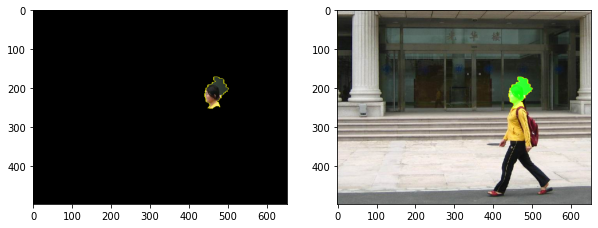

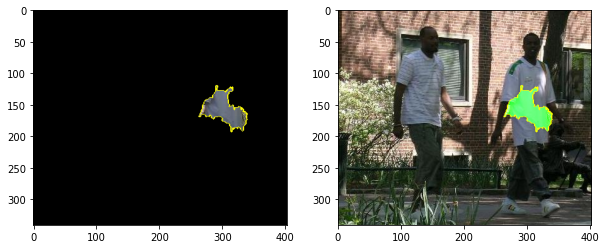

In [ ]:
from skimage.segmentation import mark_boundaries

for i in range(num_image_test):
  temp_1, mask_1 = explanations[i].get_image_and_mask(explanations[i].top_labels[0], positive_only=True, num_features=1, hide_rest=True) # <- consider only the most positive superpixel
  temp_2, mask_2 = explanations[i].get_image_and_mask(explanations[i].top_labels[0], positive_only=False, num_features=1, hide_rest=False)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
  ax1.imshow(mark_boundaries(temp_1, mask_1))
  ax2.imshow(mark_boundaries(temp_2, mask_2))
  # ax1.axis('off')
  # ax2.axis('off')

Run Rise explanation for 5 images with N=1000.

In [ ]:
sals = []
num_masks = 1000
for img in image_test:
  img = img[0].permute(1,2,0)
  sal, preds, masks = explainer_sodex.get_rise_explanation(img, N=num_masks, s=10, p1=0.5) 
  sals.append(sal)

Explaining: 100%|██████████| 1000/1000 [03:37<00:00,  4.59it/s]


Compute pointing game accuracy.

In [ ]:
evaluate(sals,image_test)

Visualize the results including detections, explanations, max. point of the saliency map (white circle).

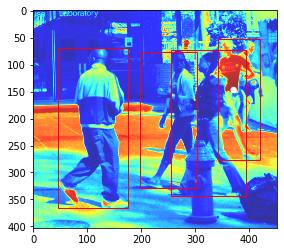

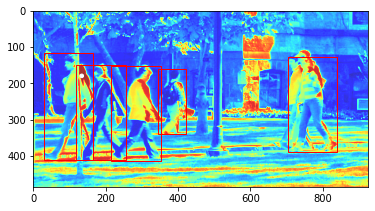

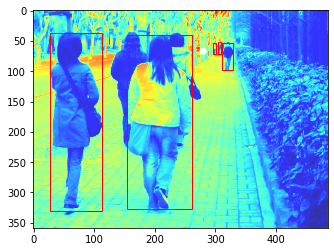

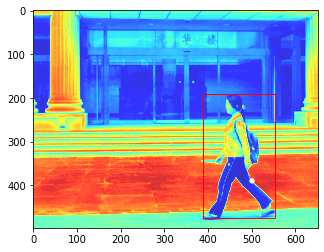

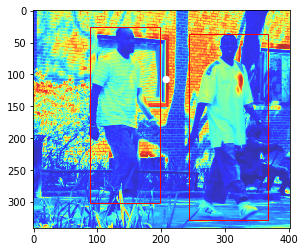

In [ ]:
from matplotlib.patches import Rectangle

for i, sal in enumerate(sals):
  # visualize saliency maps
  plt.imshow(sal.cpu().numpy(), cmap='jet', alpha=0.8)
  
  # visualize annotated bboxes
  for bbox in image_test[i][1]["boxes"]:
    width, height = bbox[2] - bbox[0], bbox[3] - bbox[1]
    rect = Rectangle((bbox[0],bbox[1]),width,height,edgecolor='r',facecolor='none')
    plt.gca().add_patch(rect)
  
  # visualize the max.point
  y,x = get_maximum_point(sal)
  circle = plt.Circle((x, y), 5, color='w')
  plt.gca().add_patch(circle)
  plt.show()